In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import leastsq, minimize
from numpy.linalg import inv
import matplotlib.pyplot as plt

# Reading in the data
# For some reason no matter what I do, I lose precision
# Also did my own formatting of the data to make it pandas readable
dt = pd.read_table('data.txt',sep=' ')




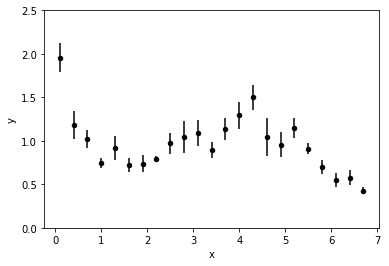

In [8]:
'''
Part A
'''

dt.plot.scatter('x','y',yerr='yerr',color='black')
plt.ylim(0,2.5)
plt.savefig('plots/p2_a.png')
plt.show()



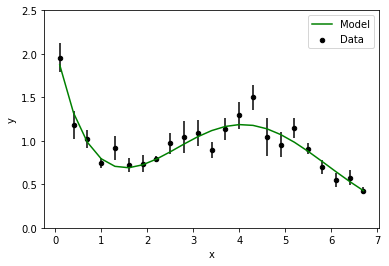

In [10]:
'''
Part B
'''

# Defining data
x = dt['x']
y = dt['y']
yerr = dt['yerr']

# Initial guess
b0 = np.array([3,2,1.5,4,2])

# Defining the model function
def model(x,b):
        return b[0]*np.exp(-b[1]*x)+b[2]*np.exp(-0.5*(x-b[3])**2/b[4]**2)
def chi_square(b):
        return np.sum(((y-model(x,b))/yerr)**2)

# Running optimization
b_opt = minimize(chi_square,b0)

# Running model with parameters
y_model = model(x,b_opt.x)

# Plotting
dt.plot.scatter('x','y',yerr='yerr',color='black',label='Data')
plt.plot(x,y_model,color='green',label='Model')
plt.legend(loc='best')
plt.savefig('p2_b.png')
plt.ylim(0,2.5)
plt.show()



In [12]:
'''
Part C
'''

# Scipy minimize returns the inverse Hessian, so to obtain the Hessian, all we have to do is use
# Numpy's inverse function

hess = b_opt.hess_inv
hess = inv(hess)

covar = inv(0.5*hess)

print('This is the Hessian',hess)
print('This is the covariance',covar)



('This is the Hessian', array([[ 155.41039247, -185.47752889,  134.91074235, -129.12943443,
         188.08723927],
       [-185.47752889,  376.83533292, -446.72572442,  343.25307889,
        -445.85369922],
       [ 134.91074235, -446.72572442, 2310.50102556, -144.41214458,
        1185.11063127],
       [-129.12943443,  343.25307889, -144.41214458,  788.32883145,
        -129.28495678],
       [ 188.08723927, -445.85369922, 1185.11063127, -129.28495678,
        1015.55677853]]))
('This is the covariance', array([[ 0.03915574,  0.03245568,  0.0010431 , -0.00671938,  0.00492428],
       [ 0.03245568,  0.05576366, -0.00135007, -0.01626358,  0.01797564],
       [ 0.0010431 , -0.00135007,  0.00235412,  0.00062355, -0.00345368],
       [-0.00671938, -0.01626358,  0.00062355,  0.00770675, -0.00564219],
       [ 0.00492428,  0.01797564, -0.00345368, -0.00564219,  0.01226111]]))


In [14]:
'''
Part D
'''
def sigma(array):
        '''
        This function finds the individual errors of the parameters 
        using the covariance array
        '''
        sigma = []
        for i in range(array.shape[0]):
                sigma.append(np.sqrt(array[i][i]))
        return np.array(sigma)


err = sigma(covar)
print(err)



[0.1978781  0.23614331 0.04851931 0.0877881  0.11072989]


In [22]:
'''
Part E
'''
def marginalize(array,para_1,para_2):
        '''
        Will marginalize all the parameters except the ones inputted
        and return the NxN hessian and covariance of inputted parameters
        '''
        p1 = para_1 - 1
        p2 = para_2 - 1

        c_ii = array[p1][p1]
        c_ij = array[p1][p2]
        c_ji = array[p2][p1]
        c_jj = array[p2][p2]

        hess = np.array([[c_ii,c_ji],[c_ij,c_jj]])
        covar = inv(0.5*hess)
        return hess, covar

hess_m, covar_m = marginalize(hess,3,5)

sigma_m = sigma(covar_m)

In [23]:
sigma_m

array([0.04643563, 0.070041  ])